In [153]:
import pandas as pd
import numpy as np
import datetime
import shap
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from src.utils.functions import mkdir_if_not_exists, write_test_json, write_json_file, read_json_file
from typing import Tuple
shap.initjs()

In [3]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()


In [135]:
df = pd.read_csv('data/Pecanstreet/participants_data/1hour/features/661_test_30_all_features.csv')
df.tail()

,year,month,day,hour,consumption,generation,dayOfWeek,dayOfYear,maxtempC,mintempC,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,prev_consumption,consumption_change
8754,2018,12,31,1,129.382,0.0,0,365,17,5,...,100,94,1.6,1011,6,7,248,9,202.808,-73.426
8755,2018,12,31,1,114.783,0.0,0,365,17,5,...,100,94,1.6,1011,6,7,248,9,129.382,-14.599
8756,2018,12,31,1,98.353,0.0,0,365,17,5,...,100,94,1.6,1011,6,7,248,9,114.783,-16.430
8757,2018,12,31,1,118.979,0.0,0,365,17,5,...,100,94,1.6,1011,6,7,248,9,98.353,20.626
8758,2018,12,31,1,108.874,0.0,0,365,17,5,...,100,94,1.6,1011,6,7,248,9,118.979,-10.105


In [136]:
df.shape

(8759, 29)

In [137]:
df.isnull().sum()

year                  0
month                 0
day                   0
hour                  0
consumption           0
generation            0
dayOfWeek             0
dayOfYear             0
maxtempC              0
mintempC              0
totalSnow_cm          0
sunHour               0
uvIndex               0
moon_illumination     0
DewPointC             0
FeelsLikeC            0
HeatIndexC            0
WindChillC            0
WindGustKmph          0
cloudcover            0
humidity              0
precipMM              0
pressure              0
tempC                 0
visibility            0
winddirDegree         0
windspeedKmph         0
prev_consumption      0
consumption_change    0
dtype: int64

In [138]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(df)
data = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

In [139]:
scaler.min_[4]

-1.0

In [140]:
X = data.copy()
X.drop('consumption', axis=1, inplace=True)
X.head()

,year,month,day,hour,generation,dayOfWeek,dayOfYear,maxtempC,mintempC,totalSnow_cm,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,prev_consumption,consumption_change
0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-1.000000,-0.206805
1,-1.0,-1.0,-1.0,-1.0,-0.999957,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.920815,-0.063264
2,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.709946,-0.247899
3,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.770316,-0.212324
4,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-0.866667,-0.878788,-1.0,...,0.86,-0.242424,-1.0,0.72973,-0.828571,1.0,-0.955432,0.333333,-0.778424,-0.237987


In [141]:
y = data['consumption']
y.describe().transpose()

count    8759.000000
mean       -0.691819
std         0.342750
min        -1.000000
25%        -0.920525
50%        -0.833773
75%        -0.557546
max         1.000000
Name: consumption, dtype: float64

In [11]:
n = len(data)
X_train, y_train = X[:int(0.7*n)], y[:int(0.7*n)]
X_validation, y_validation = X[int(.7 * n): int(n * (1.1 - .2))], y[int(.7 * n): int(n * (1.1 - .2))]
X_test, y_test = X[int(n * (1.1 - .2)):], y[int(n * (1.1 - .2)): ]


In [12]:
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(8759, 28) (8759,)
(6131, 28) (6131,)
(1752, 28) (1752,)
(876, 28) (876,)


In [142]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate': [0.1, .01, .05],
    'gamma': [0, .25, 1],
    'reg_lambda': [0, 1, 10],
    'scale_pos_weight': [1, 3, 5]
}
second_param_grid = {
    'max_depth':[4],
    'learning_rate': [0.1, .5, 1],
    'gamma': [.25],
    'reg_lambda': [10, 20, 100],
    'scale_pos_weight': [3]
}


optimal_params = GridSearchCV(estimator=XGBRegressor(seed=42,
                                                          subsample=0.9,
                                                          colsample_bytree=.5),
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             verbose=0,
                             n_jobs=10,
                             cv=10)

optimal_params.fit(X_train, 
                   y_train, 
                    eval_set=[(X_validation, y_validation)],
                  verbose=False)
print(optimal_params.best_params_)


{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 0, 'scale_pos_weight': 5}


In [13]:
xg_regressor = XGBRegressor(seed=0, objective='reg:squarederror',
                            gamma=1, 
                            learning_rate=0.1, 
                            max_depth=4, 
                            reg_lambda=0, 
                            scale_pos_weight=1)

In [14]:
xg_regressor.fit(X_train, y_train, 
                 eval_set=[(X_train, y_train), (X_validation, y_validation)], 
                 eval_metric=['rmse', 'mae', 'mape'],
                
                 verbose=False)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0, ...)

In [169]:
explainer = shap.TreeExplainer(xg_regressor)
shap_values = explainer.shap_values(X_validation)

In [170]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_validation.iloc[0,:])

In [171]:
shap.force_plot(explainer.expected_value, shap_values, X_train)

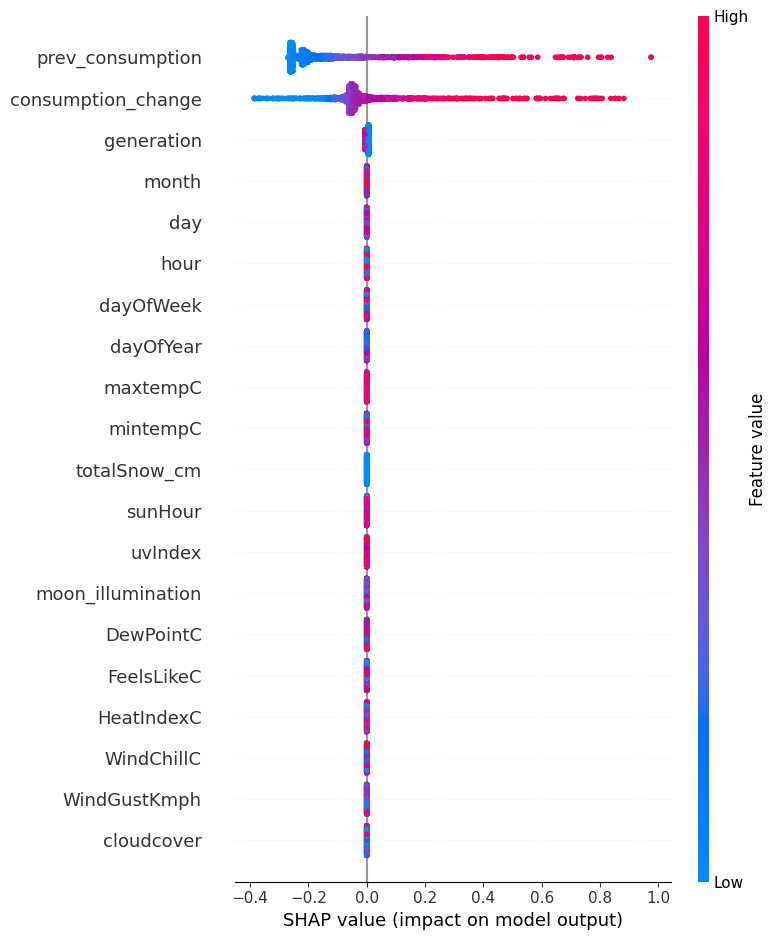

In [172]:
shap.summary_plot(shap_values, X_validation)

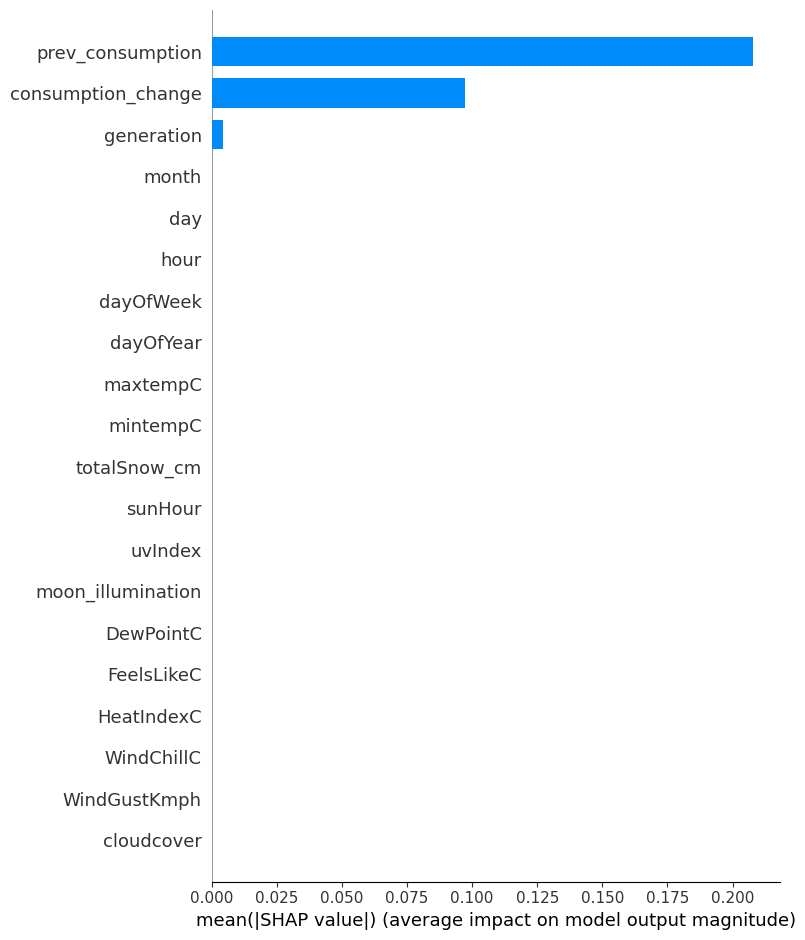

In [173]:
shap.summary_plot(shap_values, X_validation, plot_type="bar")